#Signal to Noise Calculations

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

###Dragonfly instrumentation data
Listing some values gathered from the Dragonfly Telephoto Instrumentation paper (Abraham and van Dokkum 2014), as well as sky background from the Gemini Sky Observatory (www.gemini.edu).

Some typical values I've used for the number of pixels to bin over:
- $numpixels = [(2*60*2*60)/(pixsize**2)]$ for HI clouds & for back of the envelope calculation (used by Donahue et al 1995)
- $numpixels = np.array([(100.*100.)/(pixsize**2),(10.*10.)/(pixsize**2),1.])$ for IGM filaments (from Bertone et al 2010, Fig2)
- $numpixels = [7405.]$ for azithumally averaged galaxy, at radius 80kpc, distance 50 Mpc
- $numpixels = [3700.]$ for azithumally averaged galaxy, at radius 80kpc, distance 100 Mpc
- $numpixels = [1.]$ for H alpha testing fields -Cygnus loop


In [49]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [50]:
def Dragonfly():
    area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2               # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    QE = 0.48     # quantum efficiency of the CCDs
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  # sky background at 565.6 nm 
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)

    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]



### Haloes of galaxies
In this section, I'll put together the basic calculation I've been doing to determine the signal-to-noise ratio for observations of H$\alpha$ emission from the haloes of galaxies.

I'll restate from above:
- $numpixels = [7405.]$ for azithumally averaged galaxy, at radius 80kpc, distance 50 Mpc
- $numpixels = [3700.]$ for azithumally averaged galaxy, at radius 80kpc, distance 100 Mpc


In [51]:
# pick numpixels:
numpixel = 3700.

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared] = Dragonfly()

print([area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared])
wavelen = 656.3e-9 * u.m

### SB of extended halos
SB_ph_upper = 2245.38 * u.photon / (u.cm**2 * u.rad**2 * u.second) # threshold from Steidel et al 2011 plus long translations
SB_ph_lower = 559.60 * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013

print('Surface brightness: '+str(SB_ph))

[<Quantity 7709.091380790922 cm2>, <Quantity 1.8427438923353984e-10 rad2>, 2.8, 0.85, 1.0, 0.48, <Quantity 0.52135 ph / (arcsec2 m2 nm s)>, <Quantity 0.04 ph / s>, <Quantity 100.0 ph>]
Surface brightness: 559.6 ph / (cm2 rad2 s)


Halpha Signal: 0.00130142212931 ph / s
Background Sky: 3.85681880622 ph / s
Halpha Signal: 0.000324344130421 ph / s
Background Sky: 3.85681880622 ph / s


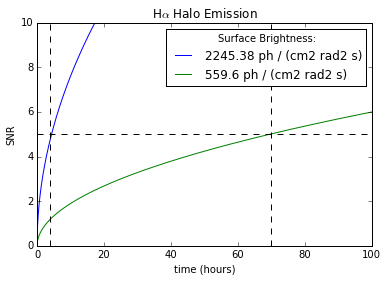

In [52]:
# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*100.)* u.second
limit = time[-1]/u.second

for SB_ph in [SB_ph_upper, SB_ph_lower]:
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    plt.plot(time/3600., signal/sigma, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))

plt.plot([0,limit/3600.],[5,5],'k--')   
plt.title(r'H$\alpha$ Halo Emission')
plt.legend(title='Surface Brightness:')
plt.xlim(0,limit/3600.)
plt.ylim(0,10)
plt.xlabel('time (hours)')
plt.ylabel('SNR')

plt.plot([4.,4.],[0,10],'k--')  # ~4 hour ~250min
plt.plot([70,70],[0,10],'k--')  # ~70 hour ~4200min


plt.savefig('HalphaHaloEmission.pdf')


In [53]:
70*60


4200